## Importar librerias

In [1]:
# Manejo de datos
import numpy as np
import pandas as pd
import os
from datetime import datetime

# Gráficos (Incluidos únicamente en el archivo .ipybn)
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Preprocesado y modelado
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import skforecast
from skforecast.recursive import ForecasterRecursive
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import grid_search_forecaster
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Configuración warnings (Quitar en caso de errores desconocidos)
import warnings
warnings.filterwarnings('ignore')

# Versión de paquetes usados
color = '\033[1m\033[38;5;208m'
print(f"{color}Versión de las librerias utilizadas:")
print(f"{color}- Version skforecast: {skforecast.__version__}")
print(f"{color}- Version scikit-learn: {sklearn.__version__}")
print(f"{color}- Version pandas: {pd.__version__}")
print(f"{color}- Version numpy: {np.__version__}")

Versión de las librerias utilizadas:
- Version skforecast: 0.14.0
- Version scikit-learn: 1.5.0
- Version pandas: 2.2.3
- Version numpy: 1.26.4


## Funciones de utilidad

In [2]:
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calcula el error porcentual absoluto medio.
    
    Parámetros:
    y_true (np.array): Valores reales.
    y_pred (np.array): Valores predichos.
    
    Retorna:
    float: Error porcentual absoluto medio.
    """
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Lectura del dataset

In [3]:
# Cargar el archivo Excel
df = pd.read_excel("accesos.xlsx")

# Leer días de vacaciones desde un archivo txt
with open('dias_vacaciones.txt', 'r') as f:
    dias_vacaciones = [pd.to_datetime(line.strip(), errors='coerce') for line in f if line.strip()]

# Asegurar que la fecha esté en formato datetime
df['Fecha Completa'] = pd.to_datetime(df['Fecha Completa'])

# Crear variables temporales relevantes
df['Día'] = df['Fecha Completa'].dt.day
df['Mes'] = df['Fecha Completa'].dt.month
df['Año'] = df['Fecha Completa'].dt.year

# Codificar Jornada, Pregrado y Postgrado
df['Jornada'] = df['Jornada'].astype('category').cat.codes
df['Pregrado'] = df['Pregrado'].map({'SI': 1, 'NO': 0})
df['Postgrado'] = df['Postgrado'].map({'SI': 1, 'NO': 0})

# Crear una clave de fecha sin hora
df['Fecha'] = df['Fecha Completa'].dt.date

# Crear columna exógena de vacaciones
df['Vacaciones'] = df['Fecha Completa'].dt.normalize().isin(dias_vacaciones).astype(int)

# Agrupar y contar accesos
daily_counts = df.groupby(['Fecha', 'Día', 'Mes', 'Año']).agg({
    'Pregrado': 'sum',
    'Postgrado': 'sum',
    'Fecha Completa': 'count',  # esto cuenta los accesos
    'Vacaciones': 'max'  # max para saber si es día de vacaciones
}).rename(columns={'Fecha Completa': 'Accesos'}).reset_index()

# Crear rango completo de fechas
fecha_inicio = df['Fecha'].min()
fecha_fin = df['Fecha'].max()
fechas_completas = pd.DataFrame({'Fecha': pd.date_range(fecha_inicio, fecha_fin)})

# Extraer día, mes y año para el rango completo
fechas_completas['Día'] = fechas_completas['Fecha'].dt.day
fechas_completas['Mes'] = fechas_completas['Fecha'].dt.month
fechas_completas['Año'] = fechas_completas['Fecha'].dt.year
fechas_completas['Fecha'] = fechas_completas['Fecha'].dt.date 

# Marcar vacaciones en el rango completo
fechas_completas['Vacaciones'] = pd.to_datetime(fechas_completas['Fecha']).isin(dias_vacaciones).astype(int)

# Unir con daily_counts
daily_counts_full = fechas_completas.merge(
    daily_counts.drop(columns=['Vacaciones']),  # quitamos la columna para evitar duplicados
    on=['Fecha', 'Día', 'Mes', 'Año'],
    how='left'
)

# Rellenar NaN con 0 en las columnas numéricas
for col in ['Pregrado', 'Postgrado', 'Accesos']:
    daily_counts_full[col] = daily_counts_full[col].fillna(0).astype(int)


In [4]:
# ...existing code...

# Rellenar NaN con 0 en las columnas numéricas
for col in ['Pregrado', 'Postgrado', 'Accesos']:
    daily_counts_full[col] = daily_counts_full[col].fillna(0).astype(int)

# Eliminar los domingos del DataFrame
daily_counts_full = daily_counts_full[
    pd.to_datetime(daily_counts_full['Fecha']).dt.weekday != 6
].reset_index(drop=True)

# ...continúa con el resto del código...

In [5]:
daily_counts_full.head(10)

,Fecha,Día,Mes,Año,Vacaciones,Pregrado,Postgrado,Accesos
0,2023-12-14,14,12,2023,0,665,17,953
1,2023-12-15,15,12,2023,0,395,5,549
2,2023-12-16,16,12,2023,0,48,2,71
3,2023-12-18,18,12,2023,0,500,15,739
4,2023-12-19,19,12,2023,0,244,8,383
5,2023-12-20,20,12,2023,0,133,6,239
6,2023-12-21,21,12,2023,0,123,10,211
7,2023-12-22,22,12,2023,1,48,4,122
8,2023-12-23,23,12,2023,0,0,0,0
9,2023-12-25,25,12,2023,1,0,0,0


In [6]:
daily_counts_full.tail(10)

,Fecha,Día,Mes,Año,Vacaciones,Pregrado,Postgrado,Accesos
428,2025-04-26,26,4,2025,0,485,7,526
429,2025-04-28,28,4,2025,0,2336,19,2400
430,2025-04-29,29,4,2025,0,2496,18,2568
431,2025-04-30,30,4,2025,0,1663,13,1705
432,2025-05-01,1,5,2025,1,0,0,0
433,2025-05-02,2,5,2025,1,0,0,0
434,2025-05-03,3,5,2025,0,0,0,0
435,2025-05-05,5,5,2025,0,2688,15,2750
436,2025-05-06,6,5,2025,0,1808,5,1866
437,2025-05-07,7,5,2025,0,2211,5,2254


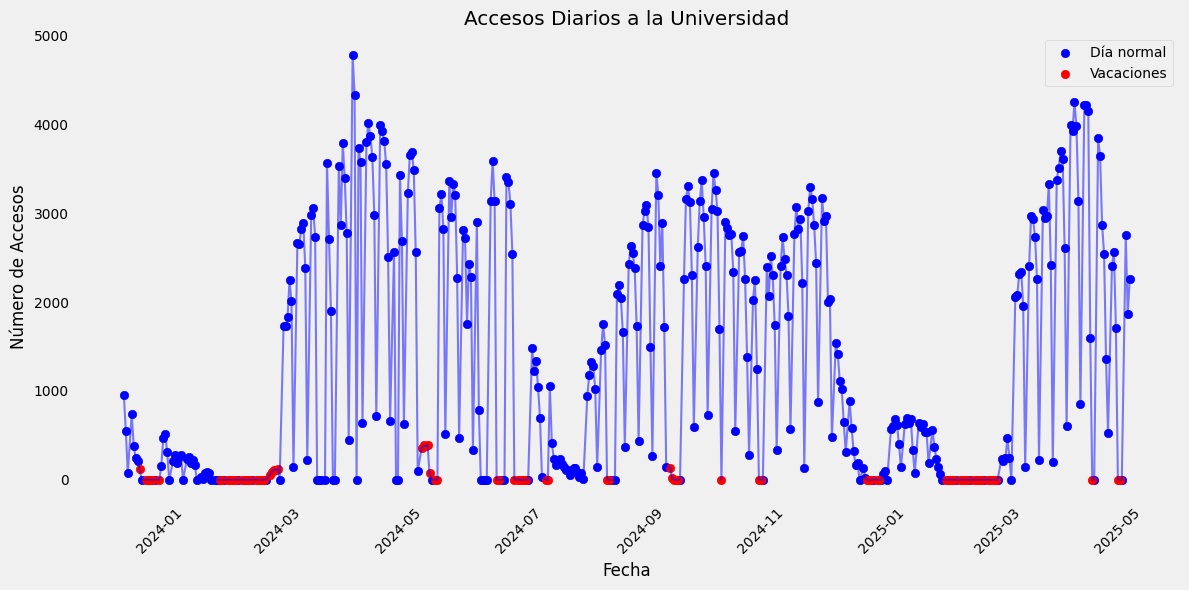

In [7]:
# Graficar los datos con puntos rojos en vacaciones
plt.figure(figsize=(12, 6))

# Línea general
plt.plot(daily_counts_full['Fecha'], daily_counts_full['Accesos'], linestyle='-', color='b', alpha=0.5)

# Puntos normales (no vacaciones)
no_vac = daily_counts_full['Vacaciones'] == 0
plt.scatter(daily_counts_full['Fecha'][no_vac], daily_counts_full['Accesos'][no_vac], color='b', label='Día normal')

# Puntos de vacaciones
vac = daily_counts_full['Vacaciones'] == 1
plt.scatter(daily_counts_full['Fecha'][vac], daily_counts_full['Accesos'][vac], color='r', label='Vacaciones')

plt.title('Accesos Diarios a la Universidad')
plt.xlabel('Fecha')
plt.ylabel('Número de Accesos')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

## División de datos de entrenamiento y test


In [8]:
train_Size = int(len(daily_counts_full)*0.8)

train = daily_counts_full['Accesos'][:train_Size]
test = daily_counts_full['Accesos'][train_Size:]

train_exog = daily_counts_full[['Vacaciones']][:train_Size]
test_exog = daily_counts_full[['Vacaciones']][train_Size:]

print(f"Train dates : {train.index.min()} --- {train.index.max()}  (n={len(train)})")
print(f"Test dates  : {test.index.min()} --- {test.index.max()}  (n={len(test)})")

Train dates : 0 --- 349  (n=350)
Test dates  : 350 --- 437  (n=88)


## Escalar los datos

In [9]:
# Escalar solo la variable objetivo (Accesos)
scaler_y = StandardScaler()
train_scaled = scaler_y.fit_transform(train.values.reshape(-1, 1))
test_scaled = scaler_y.transform(test.values.reshape(-1, 1))

# Escalar variables exógenas (Vacaciones), si lo deseas
scaler_exog = StandardScaler()
train_exog_scaled = scaler_exog.fit_transform(train_exog)
test_exog_scaled = scaler_exog.transform(test_exog)

## Crear modelo


In [10]:
# Crear y entrenar el modelo   
Daily_Use = ForecasterRecursive(
    regressor = RandomForestRegressor(random_state=123),
    lags = 3
)

Daily_Use.fit(y=train, exog=train_exog)

In [11]:
cv = TimeSeriesFold(
      steps              = 12,
      initial_train_size = int(len(train) * 0.5),
      refit              = True,
      fixed_train_size   = False,

    )

# Valores candidatos para los hiperparámetros
lags_grid = [3, 4, 6] 

param_grid = {
    'n_estimators': [100, 250, 500],
    'max_depth': [3, 5, 8, 15, 25],
}

results_grid = grid_search_forecaster(
                    forecaster  = Daily_Use,
                    y           = train,
                    cv          = cv,
                    param_grid  = param_grid,
                    lags_grid   = lags_grid,
                    metric      = 'mean_squared_error',  
                    return_best = True,
                    n_jobs      = 'auto',
                    verbose     = False,
                    exog = train_exog
                )

lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/15 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6] 
  Parameters: {'max_depth': 8, 'n_estimators': 100}
  Backtesting metric: 633489.2420650963


In [20]:
regressor = RandomForestRegressor(n_estimators=100, max_depth=8, random_state=123)
forecaster = ForecasterRecursive(
                 regressor = regressor,
                 lags      = 6
             )
forecaster.fit(y=train, exog = train_exog)


## Evaluación de rendimiento

In [21]:
predicted = forecaster.predict(steps=len(test), exog=test_exog)

In [22]:
predicted

350    421.233931
351    515.911547
352    597.813783
353    513.379194
354    575.692509
          ...    
433    658.336629
434    510.468301
435    474.655180
436    498.363133
437    505.924393
Name: pred, Length: 88, dtype: float64

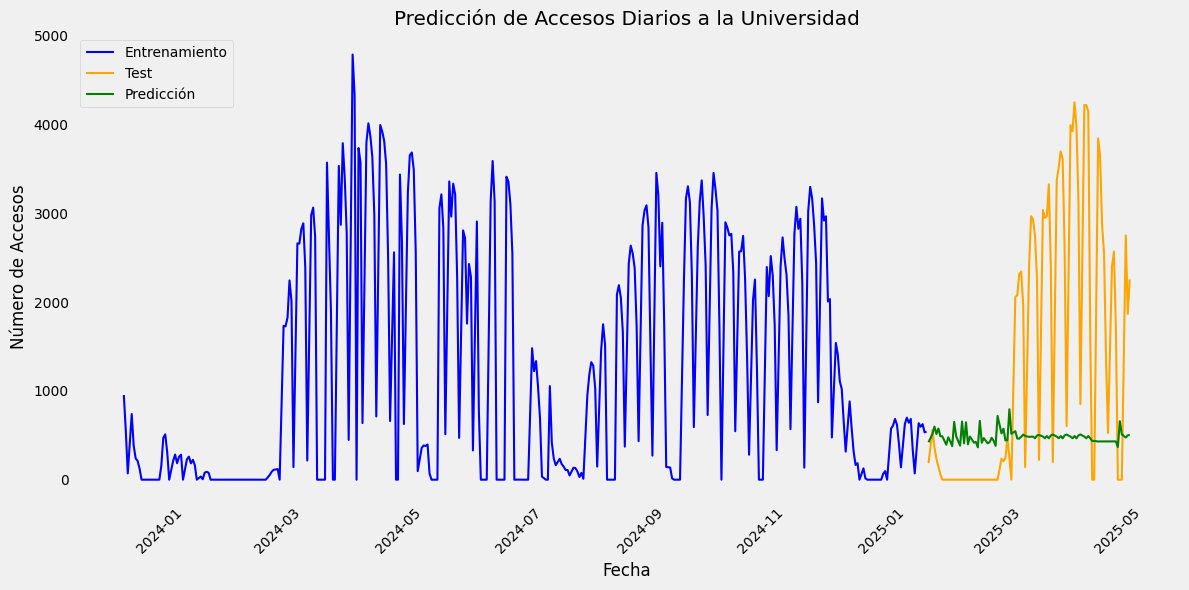

Error Cuadrático Medio (MSE): 3107553.91
Error Absoluto Medio (MAE): 1331.86
Error Porcentual Absoluto Medio (MAPE): inf%


In [23]:
# Grafico
plt.figure(figsize=(12, 6))
plt.plot(daily_counts_full['Fecha'][:train_Size], train, label='Entrenamiento', color='blue')
plt.plot(daily_counts_full['Fecha'][train_Size:], test, label='Test', color='orange')
plt.plot(daily_counts_full['Fecha'][train_Size:], predicted, label='Predicción', color='green')
plt.title('Predicción de Accesos Diarios a la Universidad')
plt.xlabel('Fecha')
plt.ylabel('Número de Accesos')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
# Evaluación del modelo
mse = mean_squared_error(test, predicted)
mae = mean_absolute_error(test, predicted)
mape = mean_absolute_percentage_error(test, predicted)
print(f"Error Cuadrático Medio (MSE): {mse:.2f}")
print(f"Error Absoluto Medio (MAE): {mae:.2f}")
print(f"Error Porcentual Absoluto Medio (MAPE): {mape:.2f}%")


In [16]:
# ...existing code...

# Rellenar NaN con 0 en las columnas numéricas
for col in ['Pregrado', 'Postgrado', 'Accesos']:
    daily_counts_full[col] = daily_counts_full[col].fillna(0).astype(int)

# Eliminar los domingos del DataFrame
daily_counts_full = daily_counts_full[
    pd.to_datetime(daily_counts_full['Fecha']).dt.weekday != 6
].reset_index(drop=True)

# ...continúa con el resto del código...

In [17]:
# ...existing code...

# Rellenar NaN con 0 en las columnas numéricas
for col in ['Pregrado', 'Postgrado', 'Accesos']:
    daily_counts_full[col] = daily_counts_full[col].fillna(0).astype(int)

# Eliminar los domingos del DataFrame
daily_counts_full = daily_counts_full[
    pd.to_datetime(daily_counts_full['Fecha']).dt.weekday != 6
].reset_index(drop=True)

# ...continúa con el resto del código...

In [18]:
# ...existing code...

# Rellenar NaN con 0 en las columnas numéricas
for col in ['Pregrado', 'Postgrado', 'Accesos']:
    daily_counts_full[col] = daily_counts_full[col].fillna(0).astype(int)

# Eliminar los domingos del DataFrame
daily_counts_full = daily_counts_full[
    pd.to_datetime(daily_counts_full['Fecha']).dt.weekday != 6
].reset_index(drop=True)

# ...continúa con el resto del código...

In [19]:
# ...existing code...

# Rellenar NaN con 0 en las columnas numéricas
for col in ['Pregrado', 'Postgrado', 'Accesos']:
    daily_counts_full[col] = daily_counts_full[col].fillna(0).astype(int)

# Eliminar los domingos del DataFrame
daily_counts_full = daily_counts_full[
    pd.to_datetime(daily_counts_full['Fecha']).dt.weekday != 6
].reset_index(drop=True)

# ...continúa con el resto del código...